In [2]:
import numpy as np
from sklearn.datasets import fetch_openml


print("Loading MNIST data...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
data = np.column_stack((mnist.target.reshape(-1, 1), mnist.data))
m, n = data.shape
np.random.shuffle(data)


test_size = 10000
data_test = data[:test_size].T
y_test = data_test[0].astype(int)
x_test = data_test[1:n]
data_train = data[test_size:].T
y_train = data_train[0].astype(int)
x_train = data_train[1:n]


x_train = x_train / 255.0
x_test = x_test / 255.0


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

y_train = one_hot(y_train)
y_test = one_hot(y_test)

print("Data preparation completed.")

Loading MNIST data...
Data preparation completed.


In [2]:
import numpy as np

def init_params():
    np.random.seed(42)
    W1 = np.random.randn(128, 784).astype(np.float64) * np.sqrt(2./784)
    b1 = np.zeros((128, 1), dtype=np.float64)
    W2 = np.random.randn(64, 128).astype(np.float64) * np.sqrt(2./128)
    b2 = np.zeros((64, 1), dtype=np.float64)
    W3 = np.random.randn(10, 64).astype(np.float64) * np.sqrt(2./64)
    b3 = np.zeros((10, 1), dtype=np.float64)
    return W1, b1, W2, b2, W3, b3

def ReLU(Z):
    return np.maximum(0, Z)

def softmax(Z):
    Z = np.array(Z, dtype=np.float64)
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, W3, b3, X):
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = ReLU(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

def compute_loss(A3, Y):
    m = Y.shape[1]
    log_probs = -np.log(np.maximum(A3[Y == 1], 1e-10))
    loss = np.sum(log_probs) / m
    return loss

def ReLU_deriv(Z):
    return Z > 0

def back_prop(X, Y, W1, b1, W2, b2, W3, b3, Z1, A1, Z2, A2, Z3, A3):
    m = X.shape[1]
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(dZ3, A2.T)
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * ReLU_deriv(Z2)
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * ReLU_deriv(Z1)
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3

def update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate):
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1    
    W2 -= learning_rate * dW2  
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3  
    b3 -= learning_rate * db3    
    return W1, b1, W2, b2, W3, b3

def get_predictions(A3):
    return np.argmax(A3, axis=0)

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y)

def gradient_descent(X, Y, learning_rate, iterations, batch_size=32):
    W1, b1, W2, b2, W3, b3 = init_params()
    num_batches = X.shape[1] // batch_size
    
    for i in range(iterations):
        for j in range(num_batches):
            start = j * batch_size
            end = start + batch_size
            X_batch = X[:, start:end]
            Y_batch = Y[:, start:end]
            
            Z1, A1, Z2, A2, Z3, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X_batch)
            dW1, db1, dW2, db2, dW3, db3 = back_prop(X_batch, Y_batch, W1, b1, W2, b2, W3, b3, Z1, A1, Z2, A2, Z3, A3)
            W1, b1, W2, b2, W3, b3 = update_params(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate)
        
        if i % 10 == 0:
            _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
            loss = compute_loss(A3, Y)
            predictions = get_predictions(A3)
            accuracy = get_accuracy(predictions, np.argmax(Y, axis=0))
            print(f"Iteration: {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return W1, b1, W2, b2, W3, b3

def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(W1, b1, W2, b2, W3, b3, X)
    predictions = get_predictions(A3)
    return predictions


x_train = np.array(x_train, dtype=np.float64)
y_train = np.array(y_train, dtype=np.float64)

print("Training the model...")
W1, b1, W2, b2, W3, b3 = gradient_descent(x_train, y_train, 0.1, 50, batch_size=32)
print("Training completed.")

Training the model...
Iteration: 0, Loss: 0.1344, Accuracy: 0.9610
Iteration: 10, Loss: 0.0115, Accuracy: 0.9963
Iteration: 20, Loss: 0.0008, Accuracy: 1.0000
Iteration: 30, Loss: 0.0003, Accuracy: 1.0000
Iteration: 40, Loss: 0.0002, Accuracy: 1.0000
Training completed.


Testing on the entire test set...
Test Accuracy: 98.06%
Visualizing some predictions...


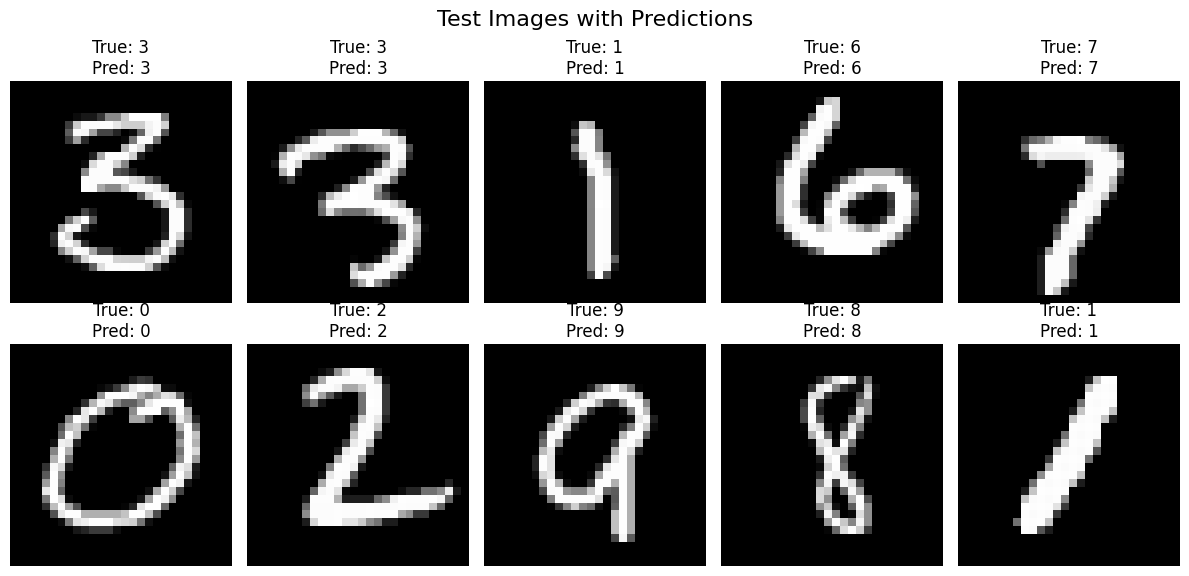


Additional Statistics:
Correct predictions: 9806 out of 10000


In [3]:
import matplotlib.pyplot as plt

def test_on_test_set(X, Y, W1, b1, W2, b2, W3, b3):
    predictions = make_predictions(X, W1, b1, W2, b2, W3, b3)
    accuracy = get_accuracy(predictions, np.argmax(Y, axis=0))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return predictions

def visualize_predictions(X, Y, predictions, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Test Images with Predictions", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            image = X[:, i].reshape(28, 28).astype(np.float64)  
            true_label = np.argmax(Y[:, i])
            predicted_label = predictions[i]
            
            ax.imshow(image, cmap='gray', vmin=0, vmax=1)  
            ax.set_title(f"True: {true_label}\nPred: {predicted_label}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Testing on the entire test set...")
test_predictions = test_on_test_set(x_test, y_test, W1, b1, W2, b2, W3, b3)

print("Visualizing some predictions...")
visualize_predictions(x_test, y_test, test_predictions)

print("\nAdditional Statistics:")
correct_predictions = np.sum(test_predictions == np.argmax(y_test, axis=0))
total_predictions = len(test_predictions)
print(f"Correct predictions: {correct_predictions} out of {total_predictions}")